## (a) Prepare Dataset

In [1]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/gtzan
!unzip gtzan.zip

/content/drive/MyDrive/gtzan
Archive:  gtzan.zip
replace gtzan/_test/classical.00000.au? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: gtzan/_test/classical.00000.au  
  inflating: gtzan/_test/classical.00001.au  
  inflating: gtzan/_test/classical.00002.au  
  inflating: gtzan/_test/classical.00003.au  
  inflating: gtzan/_test/classical.00004.au  
  inflating: gtzan/_test/classical.00005.au  
  inflating: gtzan/_test/classical.00006.au  
  inflating: gtzan/_test/classical.00007.au  
  inflating: gtzan/_test/classical.00008.au  
  inflating: gtzan/_test/classical.00009.au  
  inflating: gtzan/_test/hiphop.00000.au  
  inflating: gtzan/_test/hiphop.00001.au  
  inflating: gtzan/_test/hiphop.00002.au  
  inflating: gtzan/_test/hiphop.00003.au  
  inflating: gtzan/_test/hiphop.00004.au  
  inflating: gtzan/_test/hiphop.00005.au  
  inflating: gtzan/_test/hiphop.00006.au  
  inflating: gtzan/_test/hiphop.00007.au  
  inflating: gtzan/_test/hiphop.00008.au  
  inflating: gtzan/_te

## (b) Audio Feature Extraction

In [50]:
%cd /content
data_root = "/content/drive/MyDrive/gtzan/gtzan"  # change to the path where you store the downloaded zip file

/content


In [51]:
import os
import re
import math
import numpy as np
import librosa

In [52]:
class GenreFeatureData:
    "Music audio features for genre classification"
    hop_length = None
    genre_list = [
        "classical",
        "country",
        "disco",
        "hiphop",
        "jazz",
        "metal",
        "pop",
        "reggae",
    ]

    dir_trainfolder = os.path.join(data_root, "_train")
    dir_devfolder = os.path.join(data_root, "_validation")
    dir_testfolder = os.path.join(data_root, "_test")
    dir_all_files = data_root

    train_X_preprocessed_data = os.path.join(data_root, "data_train_input.npy")
    train_Y_preprocessed_data = os.path.join(data_root, "data_train_target.npy")
    dev_X_preprocessed_data = os.path.join(data_root, "data_validation_input.npy")
    dev_Y_preprocessed_data = os.path.join(data_root, "data_validation_target.npy")
    test_X_preprocessed_data = os.path.join(data_root, "data_test_input.npy")
    test_Y_preprocessed_data = os.path.join(data_root, "data_test_target.npy")

    train_X = train_Y = None
    dev_X = dev_Y = None
    test_X = test_Y = None

    def __init__(self):
        self.hop_length = 512

        self.timeseries_length_list = []
        self.trainfiles_list = self.path_to_audiofiles(self.dir_trainfolder)
        self.devfiles_list = self.path_to_audiofiles(self.dir_devfolder)
        self.testfiles_list = self.path_to_audiofiles(self.dir_testfolder)

        self.all_files_list = []
        self.all_files_list.extend(self.trainfiles_list)
        self.all_files_list.extend(self.devfiles_list)
        self.all_files_list.extend(self.testfiles_list)

        self.timeseries_length = (
            128
        )   # sequence length == 128, default fftsize == 2048 & hop == 512 @ SR of 22050

    def load_preprocess_data(self):
        # Training set
        self.train_X, self.train_Y = self.extract_audio_features(self.trainfiles_list)
        with open(self.train_X_preprocessed_data, "wb") as f:
            np.save(f, self.train_X)
        with open(self.train_Y_preprocessed_data, "wb") as f:
            self.train_Y = self.one_hot(self.train_Y)
            np.save(f, self.train_Y)

        # Validation set
        self.dev_X, self.dev_Y = self.extract_audio_features(self.devfiles_list)
        with open(self.dev_X_preprocessed_data, "wb") as f:
            np.save(f, self.dev_X)
        with open(self.dev_Y_preprocessed_data, "wb") as f:
            self.dev_Y = self.one_hot(self.dev_Y)
            np.save(f, self.dev_Y)

        # Test set
        self.test_X, self.test_Y = self.extract_audio_features(self.testfiles_list)
        with open(self.test_X_preprocessed_data, "wb") as f:
            np.save(f, self.test_X)
        with open(self.test_Y_preprocessed_data, "wb") as f:
            self.test_Y = self.one_hot(self.test_Y)
            np.save(f, self.test_Y)

    def extract_audio_features(self, list_of_audiofiles):
        feat_dim = 33  # TODO: define your feature dimension
        data = np.zeros(
            (len(list_of_audiofiles), self.timeseries_length, feat_dim), 
            dtype=np.float64
        )
        target = []

        for i, file in enumerate(list_of_audiofiles):
            y, sr = librosa.load(file)

            mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=self.hop_length, n_mfcc=13)
            spectral_center = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=self.hop_length)
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=self.hop_length)
            spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=self.hop_length)

            splits = re.split("[ .]", file)
            genre = re.split("[ /]", splits[0])[-1]
            target.append(genre)
            
            data[i, :, 0:13] = mfcc.T[0:self.timeseries_length, :]
            data[i, :, 13:14] = spectral_center.T[0:self.timeseries_length, :]
            data[i, :, 14:26] = chroma.T[0:self.timeseries_length, :]
            data[i, :, 26:33] = spectral_contrast.T[0:self.timeseries_length, :]
            
            print(
                "Extracted features audio track %i of %i."
                % (i + 1, len(list_of_audiofiles))
            )

        return data, np.expand_dims(np.asarray(target), axis=1)

    def one_hot(self, Y_genre_strings):
        y_one_hot = np.zeros((Y_genre_strings.shape[0], len(self.genre_list)))
        for i, genre_string in enumerate(Y_genre_strings):
            index = self.genre_list.index(genre_string)
            y_one_hot[i, index] = 1
        return y_one_hot

    @staticmethod
    def path_to_audiofiles(dir_folder):
        list_of_audio = []
        for file in os.listdir(dir_folder):
            if file.endswith(".au"):
                directory = "%s/%s" % (dir_folder, file)
                list_of_audio.append(directory)
        return list_of_audio

In [53]:
genre_features = GenreFeatureData()

print("Preprocessing raw audio files")
genre_features.load_preprocess_data()

Preprocessing raw audio files
Extracted features audio track 1 of 420.
Extracted features audio track 2 of 420.
Extracted features audio track 3 of 420.
Extracted features audio track 4 of 420.
Extracted features audio track 5 of 420.
Extracted features audio track 6 of 420.
Extracted features audio track 7 of 420.
Extracted features audio track 8 of 420.
Extracted features audio track 9 of 420.
Extracted features audio track 10 of 420.
Extracted features audio track 11 of 420.
Extracted features audio track 12 of 420.
Extracted features audio track 13 of 420.
Extracted features audio track 14 of 420.
Extracted features audio track 15 of 420.
Extracted features audio track 16 of 420.
Extracted features audio track 17 of 420.
Extracted features audio track 18 of 420.
Extracted features audio track 19 of 420.
Extracted features audio track 20 of 420.
Extracted features audio track 21 of 420.
Extracted features audio track 22 of 420.
Extracted features audio track 23 of 420.
Extracted fea

Print out the dimension of training features, valiation features, and test features, as well as the ground truths.

In [54]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [55]:
# TODO: show dimensions
train_X = torch.from_numpy(genre_features.train_X).type(torch.Tensor)
dev_X = torch.from_numpy(genre_features.dev_X).type(torch.Tensor)
test_X = torch.from_numpy(genre_features.test_X).type(torch.Tensor)
train_Y = torch.from_numpy(genre_features.train_Y).type(torch.LongTensor)
dev_Y = torch.from_numpy(genre_features.dev_Y).type(torch.LongTensor)
test_Y = torch.from_numpy(genre_features.test_Y).type(torch.LongTensor)

print("Training X shape: " + str(genre_features.train_X.shape))
print("Training Y shape: " + str(genre_features.train_Y.shape))
print("Validation X shape: " + str(genre_features.dev_X.shape))
print("Validation Y shape: " + str(genre_features.dev_Y.shape))
print("Test X shape: " + str(genre_features.test_X.shape))
print("Test Y shape: " + str(genre_features.test_Y.shape))
print("Ground truth for train:", np.where(genre_features.train_Y==1)[1])
print("Ground truth for validation:", np.where(genre_features.dev_Y==1)[1])
print("Ground truth for test:",np.where(genre_features.test_Y==1)[1])

Training X shape: (420, 128, 33)
Training Y shape: (420, 8)
Validation X shape: (120, 128, 33)
Validation Y shape: (120, 8)
Test X shape: (60, 128, 33)
Test Y shape: (60, 8)
Ground truth for train: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 4 3 3 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7

Visualize MFCC and Chromagram features.

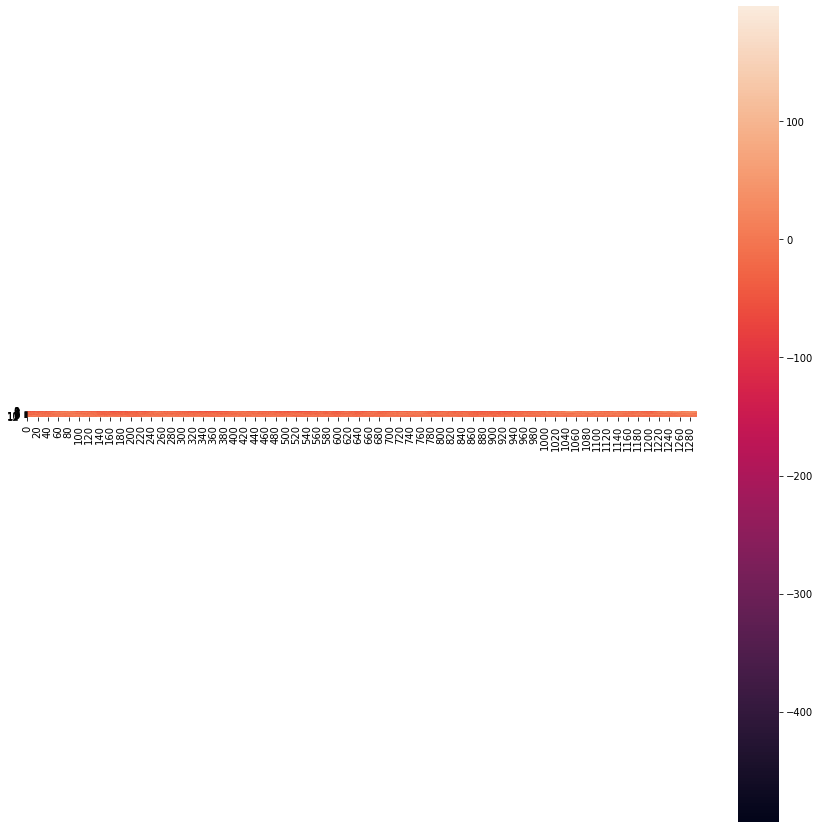

In [56]:
# TODO: visualization code
import matplotlib.pyplot as plt
import seaborn as sns

y, sr = librosa.load('/content/drive/MyDrive/gtzan/gtzan/_train/classical.00030.au')

mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)
chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
plt.figure(figsize=(15,15))
plt.imshow(mfcc)
sns.heatmap(mfcc)

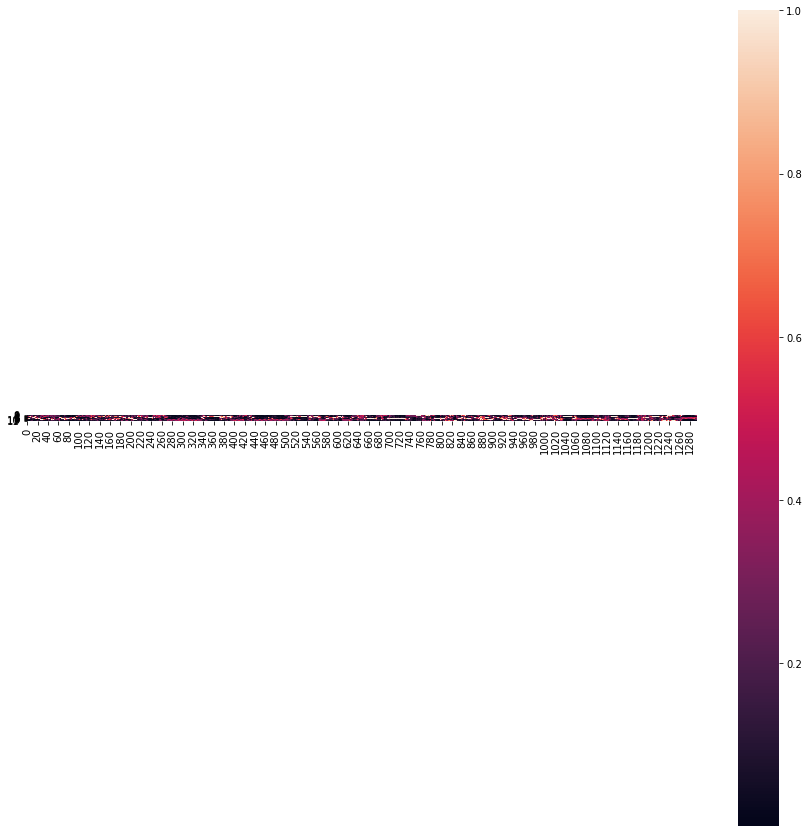

In [57]:
plt.figure(figsize=(15,15))
plt.imshow(chroma)
sns.heatmap(chroma)

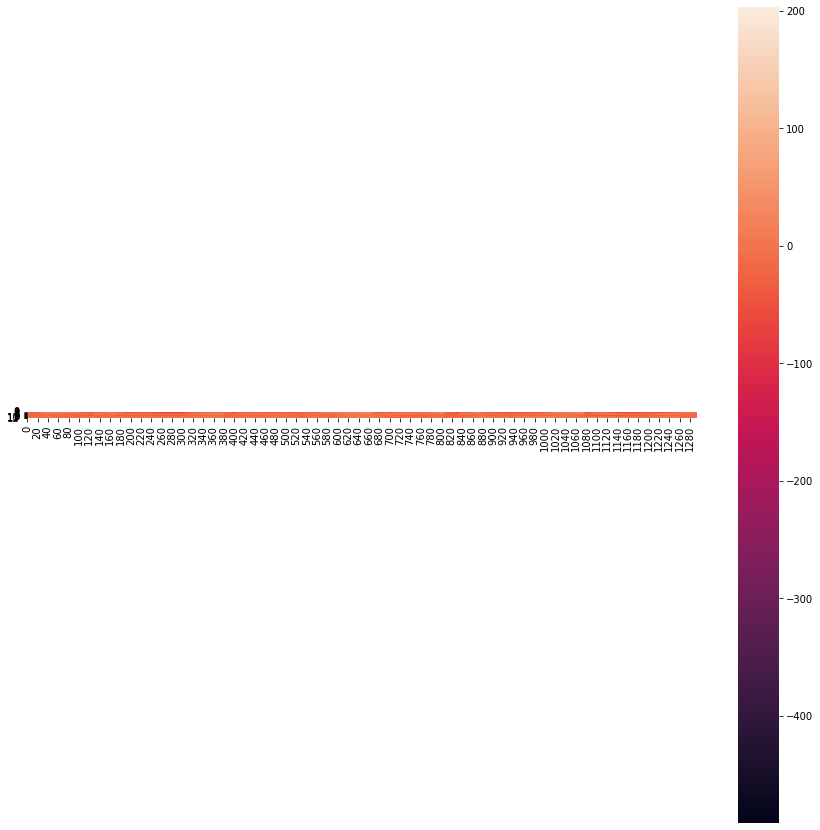

In [60]:
# TODO: visualization code
import matplotlib.pyplot as plt

y, sr = librosa.load('/content/drive/MyDrive/gtzan/gtzan/_train/jazz.00030.au')

mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)
chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
plt.figure(figsize=(15,15))
plt.imshow(mfcc)
sns.heatmap(mfcc)

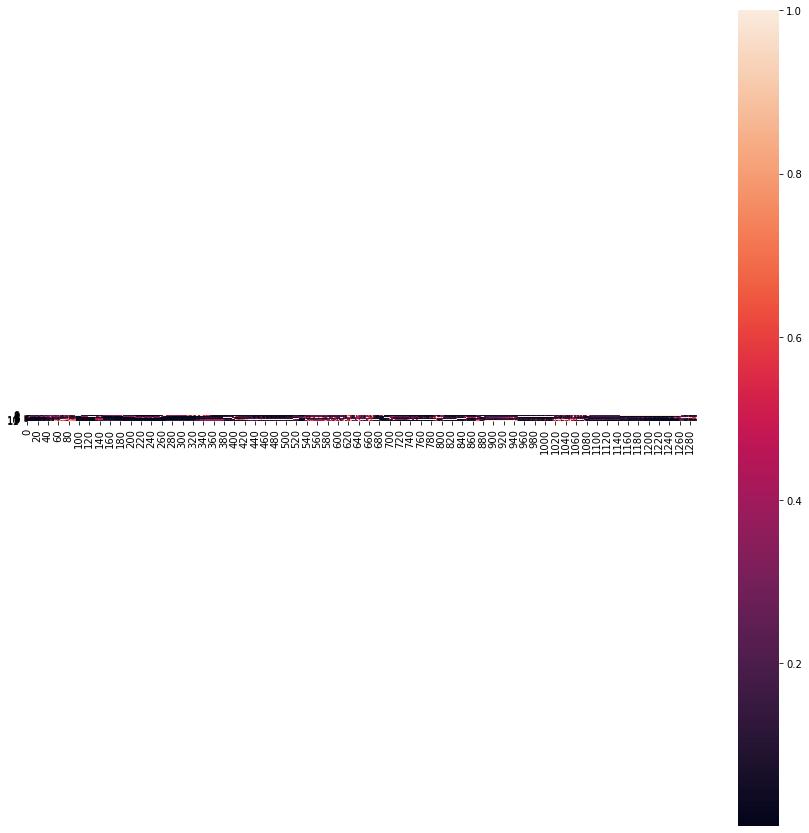

In [61]:
plt.figure(figsize=(15,15))
plt.imshow(chroma)
sns.heatmap(chroma)

## (c) LSTM Implementation

In [62]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=8, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, input, hidden=None):
        lstm_out, hidden = self.lstm(input, hidden)
        logits = self.linear(lstm_out[-1])
        genre_scores = F.log_softmax(logits, dim=1)
        return genre_scores, hidden

    def get_accuracy(self, logits, target):
        """ compute accuracy for training round """
        corrects = (
                torch.max(logits, 1)[1].view(target.size()).data == target.data
        ).sum()
        accuracy = 100.0 * corrects / self.batch_size
        return accuracy.item()

In [63]:
batch_size = 35
num_epochs = 200

# Define model
model = LSTM(input_dim=33, hidden_dim=128, batch_size=batch_size, output_dim=8, num_layers=2)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("\nTraining on GPU")
else:
    print("\nNo GPU, training on CPU")

stateful = False
num_batches = int(train_X.shape[0]/batch_size)
num_dev_batches = int(dev_X.shape[0]/batch_size)
val_loss_list, val_accuracy_list, epoch_list = [], [], []

print("Training ...")
for epoch in range(num_epochs):
    train_running_loss, train_acc = 0.0, 0.0
    hidden_state = None

    for i in range(num_batches):
        model.zero_grad()
        # TODO: training batch
        X_local_minibatch, y_local_minibatch = (train_X[i*batch_size:(i+1)*batch_size,],train_Y[i*batch_size:(i+1)*batch_size,],)   
        X_local_minibatch = X_local_minibatch.permute(1, 0, 2)
        y_local_minibatch = torch.max(y_local_minibatch, 1)[1]
        y_pred, hidden_state = model(X_local_minibatch, hidden_state)

        if not stateful:
            hidden_state = None
        else:
            h_0, c_0 = hidden_state
            h_0.detach_(), c_0.detach_()
            hidden_state = (h_0, c_0)

        loss = loss_function(y_pred, y_local_minibatch)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.detach().item()
        train_acc += model.get_accuracy(y_pred, y_local_minibatch)  

    print(
        "Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f"
        % (epoch, train_running_loss / num_batches, train_acc / num_batches)
    )

    if epoch % 10 == 0:
        print("Validation ...") 
        with torch.no_grad():
            model.eval()
            # TODO: validation batch
            val_running_loss, val_acc = 0.0, 0.0
            hidden_state = None
            for i in range(num_dev_batches):
                X_local_validation_minibatch, y_local_validation_minibatch = (dev_X[i*batch_size:(i+1)*batch_size,],dev_Y[i*batch_size:(i+1)*batch_size,],)
                X_local_minibatch = X_local_validation_minibatch.permute(1, 0, 2)
                y_local_minibatch = torch.max(y_local_validation_minibatch, 1)[1]
                #y_local_minibatch = torch.tensor(y_local_minibatch,dtype=torch.float)
                y_pred, hidden_state = model(X_local_minibatch, hidden_state)
                if not stateful:
                    hidden_state = None
                val_loss = loss_function(y_pred, y_local_minibatch)
                val_running_loss += (val_loss.detach().item())  
                val_acc += model.get_accuracy(y_pred, y_local_minibatch)

            model.train()
            print(
                "Epoch:  %d | NLLoss: %.4f | Train Accuracy: %.2f | Val Loss %.4f  | Val Accuracy: %.2f"
                % (epoch, train_running_loss / num_batches, train_acc / num_batches, val_running_loss / num_dev_batches, val_acc / num_dev_batches, ))

        epoch_list.append(epoch)
        val_accuracy_list.append(val_acc / num_dev_batches)
        val_loss_list.append(val_running_loss / num_dev_batches)
   
    # TODO: save model
    torch.save(model.state_dict(), '/content/drive/MyDrive/gtzan/model_1.pt')


Training on GPU
Training ...
Epoch:  0 | Loss: 2.1796 | Train Accuracy: 8.10
Validation ...
Epoch:  0 | NLLoss: 2.1796 | Train Accuracy: 8.10 | Val Loss 1.9057  | Val Accuracy: 32.38
Epoch:  1 | Loss: 1.9524 | Train Accuracy: 16.19
Epoch:  2 | Loss: 1.8687 | Train Accuracy: 27.62
Epoch:  3 | Loss: 1.7832 | Train Accuracy: 16.19
Epoch:  4 | Loss: 1.6806 | Train Accuracy: 16.90
Epoch:  5 | Loss: 1.5878 | Train Accuracy: 19.76
Epoch:  6 | Loss: 1.5021 | Train Accuracy: 22.38
Epoch:  7 | Loss: 1.6847 | Train Accuracy: 17.86
Epoch:  8 | Loss: 1.4935 | Train Accuracy: 21.90
Epoch:  9 | Loss: 1.5048 | Train Accuracy: 22.86
Epoch:  10 | Loss: 1.4347 | Train Accuracy: 30.00
Validation ...
Epoch:  10 | NLLoss: 1.4347 | Train Accuracy: 30.00 | Val Loss 1.2773  | Val Accuracy: 42.86
Epoch:  11 | Loss: 1.4267 | Train Accuracy: 30.24
Epoch:  12 | Loss: 1.4129 | Train Accuracy: 28.57
Epoch:  13 | Loss: 1.3666 | Train Accuracy: 35.00
Epoch:  14 | Loss: 1.3317 | Train Accuracy: 40.71
Epoch:  15 | Loss

Visualize loss during the training.

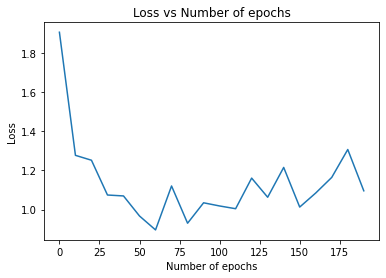

In [64]:
# TODO: visualization loss
plt.plot(epoch_list, val_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of epochs")
plt.show()

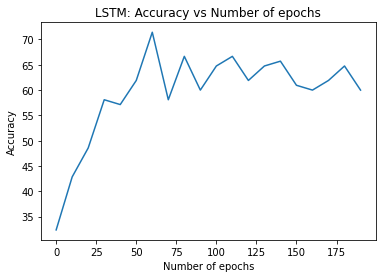

In [65]:
plt.plot(epoch_list, val_accuracy_list)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("LSTM: Accuracy vs Number of epochs")
plt.show()

## (d) Evaluation and Ablation Study

In [22]:
# TODO: evaluation on testing set
test_acc=0.0
hidden_state=None
X = test_X.permute(1, 0, 2)
y = torch.max(test_Y, 1)[1]
y_pred, hidden_state = model(X, hidden_state)
test_acc = ((torch.max(y_pred, 1)[1].view(y.size()).data == y.data).sum()*100/len(test_X)).item()
print(test_acc)

68.33333587646484


In [23]:
# TODO: train a model using MFCC features only
class GenreFeatureData:
    "Music audio features for genre classification"
    hop_length = None
    genre_list = [
        "classical",
        "country",
        "disco",
        "hiphop",
        "jazz",
        "metal",
        "pop",
        "reggae",
    ]

    dir_trainfolder = os.path.join(data_root, "_train")
    dir_devfolder = os.path.join(data_root, "_validation")
    dir_testfolder = os.path.join(data_root, "_test")
    dir_all_files = data_root

    train_X_preprocessed_data = os.path.join(data_root, "data_train_input.npy")
    train_Y_preprocessed_data = os.path.join(data_root, "data_train_target.npy")
    dev_X_preprocessed_data = os.path.join(data_root, "data_validation_input.npy")
    dev_Y_preprocessed_data = os.path.join(data_root, "data_validation_target.npy")
    test_X_preprocessed_data = os.path.join(data_root, "data_test_input.npy")
    test_Y_preprocessed_data = os.path.join(data_root, "data_test_target.npy")

    train_X = train_Y = None
    dev_X = dev_Y = None
    test_X = test_Y = None

    def __init__(self):
        self.hop_length = 512

        self.timeseries_length_list = []
        self.trainfiles_list = self.path_to_audiofiles(self.dir_trainfolder)
        self.devfiles_list = self.path_to_audiofiles(self.dir_devfolder)
        self.testfiles_list = self.path_to_audiofiles(self.dir_testfolder)

        self.all_files_list = []
        self.all_files_list.extend(self.trainfiles_list)
        self.all_files_list.extend(self.devfiles_list)
        self.all_files_list.extend(self.testfiles_list)

        self.timeseries_length = (
            128
        )   # sequence length == 128, default fftsize == 2048 & hop == 512 @ SR of 22050

    def load_preprocess_data(self):
        # Training set
        self.train_X, self.train_Y = self.extract_audio_features(self.trainfiles_list)
        with open(self.train_X_preprocessed_data, "wb") as f:
            np.save(f, self.train_X)
        with open(self.train_Y_preprocessed_data, "wb") as f:
            self.train_Y = self.one_hot(self.train_Y)
            np.save(f, self.train_Y)

        # Validation set
        self.dev_X, self.dev_Y = self.extract_audio_features(self.devfiles_list)
        with open(self.dev_X_preprocessed_data, "wb") as f:
            np.save(f, self.dev_X)
        with open(self.dev_Y_preprocessed_data, "wb") as f:
            self.dev_Y = self.one_hot(self.dev_Y)
            np.save(f, self.dev_Y)

        # Test set
        self.test_X, self.test_Y = self.extract_audio_features(self.testfiles_list)
        with open(self.test_X_preprocessed_data, "wb") as f:
            np.save(f, self.test_X)
        with open(self.test_Y_preprocessed_data, "wb") as f:
            self.test_Y = self.one_hot(self.test_Y)
            np.save(f, self.test_Y)

    def extract_audio_features(self, list_of_audiofiles):
        feat_dim = 13  # TODO: define your feature dimension
        data = np.zeros(
            (len(list_of_audiofiles), self.timeseries_length, feat_dim), 
            dtype=np.float64
        )
        target = []

        for i, file in enumerate(list_of_audiofiles):
            y, sr = librosa.load(file)

            mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=self.hop_length, n_mfcc=13)
            spectral_center = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=self.hop_length)
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=self.hop_length)
            spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=self.hop_length)

            splits = re.split("[ .]", file)
            genre = re.split("[ /]", splits[0])[-1]
            target.append(genre)
            
            data[i, :, 0:13] = mfcc.T[0:self.timeseries_length, :]
            
            print(
                "Extracted features audio track %i of %i."
                % (i + 1, len(list_of_audiofiles))
            )

        return data, np.expand_dims(np.asarray(target), axis=1)

    def one_hot(self, Y_genre_strings):
        y_one_hot = np.zeros((Y_genre_strings.shape[0], len(self.genre_list)))
        for i, genre_string in enumerate(Y_genre_strings):
            index = self.genre_list.index(genre_string)
            y_one_hot[i, index] = 1
        return y_one_hot

    @staticmethod
    def path_to_audiofiles(dir_folder):
        list_of_audio = []
        for file in os.listdir(dir_folder):
            if file.endswith(".au"):
                directory = "%s/%s" % (dir_folder, file)
                list_of_audio.append(directory)
        return list_of_audio

In [24]:
genre_features = GenreFeatureData()

print("Preprocessing raw audio files")
genre_features.load_preprocess_data()

Preprocessing raw audio files
Extracted features audio track 1 of 420.
Extracted features audio track 2 of 420.
Extracted features audio track 3 of 420.
Extracted features audio track 4 of 420.
Extracted features audio track 5 of 420.
Extracted features audio track 6 of 420.
Extracted features audio track 7 of 420.
Extracted features audio track 8 of 420.
Extracted features audio track 9 of 420.
Extracted features audio track 10 of 420.
Extracted features audio track 11 of 420.
Extracted features audio track 12 of 420.
Extracted features audio track 13 of 420.
Extracted features audio track 14 of 420.
Extracted features audio track 15 of 420.
Extracted features audio track 16 of 420.
Extracted features audio track 17 of 420.
Extracted features audio track 18 of 420.
Extracted features audio track 19 of 420.
Extracted features audio track 20 of 420.
Extracted features audio track 21 of 420.
Extracted features audio track 22 of 420.
Extracted features audio track 23 of 420.
Extracted fea

In [25]:
# TODO: show dimensions
train_X = torch.from_numpy(genre_features.train_X).type(torch.Tensor)
dev_X = torch.from_numpy(genre_features.dev_X).type(torch.Tensor)
test_X = torch.from_numpy(genre_features.test_X).type(torch.Tensor)
train_Y = torch.from_numpy(genre_features.train_Y).type(torch.LongTensor)
dev_Y = torch.from_numpy(genre_features.dev_Y).type(torch.LongTensor)
test_Y = torch.from_numpy(genre_features.test_Y).type(torch.LongTensor)

print("Training X shape: " + str(genre_features.train_X.shape))
print("Training Y shape: " + str(genre_features.train_Y.shape))
print("Validation X shape: " + str(genre_features.dev_X.shape))
print("Validation Y shape: " + str(genre_features.dev_Y.shape))
print("Test X shape: " + str(genre_features.test_X.shape))
print("Test Y shape: " + str(genre_features.test_Y.shape))
print("Ground truth for train:", np.where(genre_features.train_Y==1)[1])
print("Ground truth for validation:", np.where(genre_features.dev_Y==1)[1])
print("Ground truth for test:",np.where(genre_features.test_Y==1)[1])

Training X shape: (420, 128, 13)
Training Y shape: (420, 8)
Validation X shape: (120, 128, 13)
Validation Y shape: (120, 8)
Test X shape: (60, 128, 13)
Test Y shape: (60, 8)
Ground truth for train: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 4 3 3 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7

In [27]:
batch_size = 35
num_epochs = 100 #Lesser epochs than before as it reaches 100% accuracy

# Define model
model = LSTM(input_dim=13, hidden_dim=128, batch_size=batch_size, output_dim=8, num_layers=2)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("\nTraining on GPU")
else:
    print("\nNo GPU, training on CPU")

stateful = False
num_batches = int(train_X.shape[0]/batch_size)
num_dev_batches = int(dev_X.shape[0]/batch_size)
val_loss_list, val_accuracy_list, epoch_list = [], [], []

print("Training ...")
for epoch in range(num_epochs):
    train_running_loss, train_acc = 0.0, 0.0
    hidden_state = None

    for i in range(num_batches):
        model.zero_grad()
        # TODO: training batch
        X_local_minibatch, y_local_minibatch = (train_X[i*batch_size:(i+1)*batch_size,],train_Y[i*batch_size:(i+1)*batch_size,],)   
        X_local_minibatch = X_local_minibatch.permute(1, 0, 2)
        y_local_minibatch = torch.max(y_local_minibatch, 1)[1]
        #y_local_minibatch = torch.tensor(y_local_minibatch,dtype=torch.float)
        y_pred, hidden_state = model(X_local_minibatch, hidden_state)

        if not stateful:
            hidden_state = None
        else:
            h_0, c_0 = hidden_state
            h_0.detach_(), c_0.detach_()
            hidden_state = (h_0, c_0)

        loss = loss_function(y_pred, y_local_minibatch)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.detach().item()
        train_acc += model.get_accuracy(y_pred, y_local_minibatch)  

    print(
        "Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f"
        % (epoch, train_running_loss / num_batches, train_acc / num_batches)
    )

    if epoch % 10 == 0:
        print("Validation ...") 
        with torch.no_grad():
            model.eval()
            # TODO: validation batch
            val_running_loss, val_acc = 0.0, 0.0
            hidden_state = None
            for i in range(num_dev_batches):
                X_local_validation_minibatch, y_local_validation_minibatch = (dev_X[i*batch_size:(i+1)*batch_size,],dev_Y[i*batch_size:(i+1)*batch_size,],)
                X_local_minibatch = X_local_validation_minibatch.permute(1, 0, 2)
                y_local_minibatch = torch.max(y_local_validation_minibatch, 1)[1]
                #y_local_minibatch = torch.tensor(y_local_minibatch,dtype=torch.float)
                y_pred, hidden_state = model(X_local_minibatch, hidden_state)
                if not stateful:
                    hidden_state = None
                val_loss = loss_function(y_pred, y_local_minibatch)
                val_running_loss += (val_loss.detach().item())  
                val_acc += model.get_accuracy(y_pred, y_local_minibatch)

            model.train()
            print(
                "Epoch:  %d | NLLoss: %.4f | Train Accuracy: %.2f | Val Loss %.4f  | Val Accuracy: %.2f"
                % (epoch, train_running_loss / num_batches, train_acc / num_batches, val_running_loss / num_dev_batches, val_acc / num_dev_batches, ))

        epoch_list.append(epoch)
        val_accuracy_list.append(val_acc / num_dev_batches)
        val_loss_list.append(val_running_loss / num_dev_batches)
   
    # TODO: save model
    torch.save(model.state_dict(), '/content/drive/MyDrive/gtzan/model_2.pt')


Training on GPU
Training ...
Epoch:  0 | Loss: 2.1942 | Train Accuracy: 2.62
Validation ...
Epoch:  0 | NLLoss: 2.1942 | Train Accuracy: 2.62 | Val Loss 1.8964  | Val Accuracy: 38.10
Epoch:  1 | Loss: 1.8619 | Train Accuracy: 36.19
Epoch:  2 | Loss: 1.6417 | Train Accuracy: 45.71
Epoch:  3 | Loss: 1.3767 | Train Accuracy: 47.86
Epoch:  4 | Loss: 1.1991 | Train Accuracy: 52.86
Epoch:  5 | Loss: 1.0815 | Train Accuracy: 57.38
Epoch:  6 | Loss: 0.9818 | Train Accuracy: 60.48
Epoch:  7 | Loss: 0.8842 | Train Accuracy: 67.14
Epoch:  8 | Loss: 0.8503 | Train Accuracy: 65.48
Epoch:  9 | Loss: 0.7836 | Train Accuracy: 65.95
Epoch:  10 | Loss: 0.7422 | Train Accuracy: 71.19
Validation ...
Epoch:  10 | NLLoss: 0.7422 | Train Accuracy: 71.19 | Val Loss 1.1539  | Val Accuracy: 62.86
Epoch:  11 | Loss: 0.6857 | Train Accuracy: 74.29
Epoch:  12 | Loss: 0.6437 | Train Accuracy: 76.90
Epoch:  13 | Loss: 0.5076 | Train Accuracy: 84.29
Epoch:  14 | Loss: 0.4850 | Train Accuracy: 84.05
Epoch:  15 | Loss

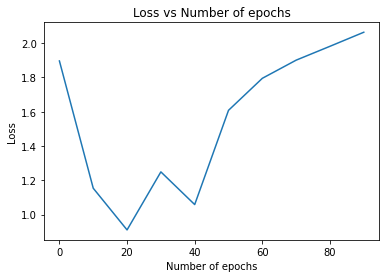

In [28]:
# TODO: visualization loss
plt.plot(epoch_list, val_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of epochs")
plt.show()

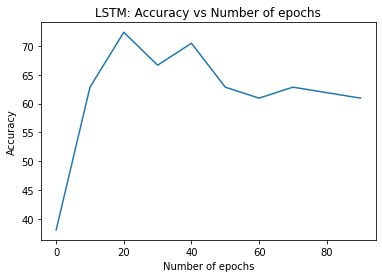

In [29]:
plt.plot(epoch_list, val_accuracy_list)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("LSTM: Accuracy vs Number of epochs")
plt.show()

In [30]:
# TODO: evaluation on testing set
test_acc=0.0
hidden_state=None
X = test_X.permute(1, 0, 2)
y = torch.max(test_Y, 1)[1]
y_pred, hidden_state = model(X, hidden_state)
test_acc = ((torch.max(y_pred, 1)[1].view(y.size()).data == y.data).sum()*100/len(test_X)).item()
print(test_acc)

60.0


## (e) Try a customized music

In [66]:
def extract_audio_features(file):
    timeseries_length = 128
    features = np.zeros((1, timeseries_length, 33), dtype=np.float64)

    y, sr = librosa.load(file)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)
    spectral_center = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=512)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=512)

    features[0, :, 0:13] = mfcc.T[0:timeseries_length, :]
    features[0, :, 13:14] = spectral_center.T[0:timeseries_length, :]
    features[0, :, 14:26] = chroma.T[0:timeseries_length, :]
    features[0, :, 26:33] = spectral_contrast.T[0:timeseries_length, :]
    return features

In [67]:
def get_genre(model, music_path):
    test_features = extract_audio_features(music_path)
    test_features = torch.from_numpy(test_features).type(torch.Tensor)
    X = test_features.permute(1, 0, 2)
    y_prediction, _ = model(X, None)
    predict_genre = torch.max(y_prediction, 1)[1].item()
    return predict_genre

In [68]:
PATH = "/content/drive/MyDrive/gtzan/Music/audio_classical_music.mp3"
GENRE = get_genre(model, PATH)
print("Model predict: {}".format(GENRE))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Model predict: 0


In [72]:
PATH = "/content/drive/MyDrive/gtzan/Music/audio_jazz_music.mp3"
GENRE = get_genre(model, PATH)
print("Model predict: {}".format(GENRE))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Model predict: 4


In [69]:
PATH = "/content/drive/MyDrive/gtzan/Music/audio_country_music.mp3"
GENRE = get_genre(model, PATH)
print("Model predict: {}".format(GENRE))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Model predict: 7


In [70]:
PATH = "/content/drive/MyDrive/gtzan/Music/audio_disco_music.mp3"
GENRE = get_genre(model, PATH)
print("Model predict: {}".format(GENRE))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Model predict: 4


In [71]:
PATH = "/content/drive/MyDrive/gtzan/Music/audio_hip-hop_music.mp3"
GENRE = get_genre(model, PATH)
print("Model predict: {}".format(GENRE))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Model predict: 7


In [73]:
PATH = "/content/drive/MyDrive/gtzan/Music/audio_metal_music.mp3"
GENRE = get_genre(model, PATH)
print("Model predict: {}".format(GENRE))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Model predict: 3


In [74]:
PATH = "/content/drive/MyDrive/gtzan/Music/audio_pop_music.mp3"
GENRE = get_genre(model, PATH)
print("Model predict: {}".format(GENRE))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Model predict: 0


In [75]:
PATH = "/content/drive/MyDrive/gtzan/Music/audio_reggae_music.mp3"
GENRE = get_genre(model, PATH)
print("Model predict: {}".format(GENRE))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Model predict: 3


As the accuracy is low, we find the prediction results of only classical and jazz genre to be matching and not for the others.